In [1]:
from astropy import units as u, constants as const
from astropy.table import Table
from astropy.io import fits
import numpy as np
from scipy import interpolate
import pandas as pd
from dust_extinction.parameter_averages import CCM89

In [6]:
G_filter = Table.read('data/GAIA.GAIA0.G.votable')
Bp_filter = Table.read('data/GAIA.GAIA0.Gbp.votable.xml', format='votable')
Rp_filter = Table.read('data/GAIA.GAIA0.Grp.votable.xml', format='votable')

VEGA_RADIUS = 2.5 * u.R_sun
VEGA_TEMPERATURE = 9607 * u.K
VEGA_DISTANCE = 25.05 * u.lightyear
VEGA_FILTER = Table.read('data/alpha_lyr_mod_004.fits', format='fits')
VEGA_WAVE = VEGA_FILTER['WAVELENGTH'].value * u.Angstrom
VEGA_FLUX = VEGA_FILTER['FLUX'].value * u.erg/u.s/u.cm**2/u.angstrom
PLEIADES_DISTANCE = 444 * u.lyr


In [7]:
def blackbody_intensity(temperature, wavelength):
    prefactor = 2 * ((const.h * const.c**2) / wavelength**5)
    return (
        prefactor
        / (np.exp((const.h * const.c) / (wavelength * const.k_B * temperature)) - 1)
    ).to(u.erg / u.s / u.cm**2 / u.angstrom)


def blackbody_flux(temperature, wavelength):
    return np.pi * blackbody_intensity(temperature, wavelength).to(
        u.erg / u.s / u.cm**2 / u.angstrom
    )


def model_star(temperature, star_radius, distance, wavelength):
    return (
        (blackbody_flux(temperature, wavelength) * star_radius**2 / distance**2)
    ).to(u.erg / u.s / u.cm**2 / u.angstrom)


In [8]:
def mean_flux_bb_filter(temperature, star_radius, distance, filter):
    flux_model = model_star(
        temperature, star_radius, distance, filter["Wavelength"].quantity
    )
    flux_int = np.trapz(
        flux_model * filter["Transmission"].quantity * filter["Wavelength"].quantity, filter["Wavelength"].quantity
    )
    filter_int = np.trapz(
        filter["Transmission"].quantity * filter["Wavelength"].quantity, filter["Wavelength"].quantity
    )
    return (flux_int / filter_int).to(u.erg / u.s / u.angstrom / u.cm**2)

def mean_flux_spectrum_filter(star_wave, star_flux, filter):
    interp_filter_transmission = np.interp(
        star_wave, filter["Wavelength"].quantity, filter["Transmission"].quantity
    )
    flux_int = np.trapz(
        star_flux * interp_filter_transmission * star_wave, star_wave
    )
    filter_int = np.trapz(
        filter["Transmission"].quantity *  filter["Wavelength"].quantity, filter["Wavelength"].quantity
    )
    return (flux_int / filter_int).to(u.erg / u.s / u.angstrom / u.cm**2)

def mean_flux_G(temperature, star_radius, distance):
    return mean_flux_bb_filter(temperature, star_radius, distance, G_filter)


def mean_flux_Bp(temperature, star_radius, distance):
    return mean_flux_bb_filter(temperature, star_radius, distance, Bp_filter)


def mean_flux_Rp(temperature, star_radius, distance):
    return mean_flux_bb_filter(temperature, star_radius, distance, Rp_filter)

In [9]:
def model_star_vega_mag(temperature, star_radius, distance, filter):
    mean_flux_bb = mean_flux_bb_filter(temperature, star_radius, distance, filter)
    mean_flux_vega = mean_flux_spectrum_filter(VEGA_WAVE, VEGA_FLUX, filter)
    return -2.5 * np.log10(mean_flux_bb / mean_flux_vega)

def model_star_cmd(temperature, star_radius, distance):
    G_mag = model_star_vega_mag(temperature, star_radius, distance, G_filter)
    Bp_mag = model_star_vega_mag(temperature, star_radius, distance, Bp_filter)
    Rp_mag = model_star_vega_mag(temperature, star_radius, distance, Rp_filter)
    return (Bp_mag - Rp_mag).value, G_mag.value

In [10]:
pleiades = Table.read('data/pleiades_prop_mot_sel.votable', format='votable')
westerlund1 = Table.read('data/westerlund1_gaiadr2_2m.votable', format='votable')
#westerlund1_oc = oc_df[oc_df['Cluster'] == 'Westerlaund_1']

In [11]:
model_star_cmd(5780 * u.K, 1 * u.R_sun, PLEIADES_DISTANCE)

(0.8593045345061512, 10.2396421730592)

In [15]:
pleiades_model_teff = np.arange(2000, 200000, 1000) * u.K
colors = []
mags = []
for teff in pleiades_model_teff:
    color, mag = model_star_cmd(teff, 1 * u.Rsun, 3.8 * u.kpc)
    colors.append(color)
    mags.append(mag)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


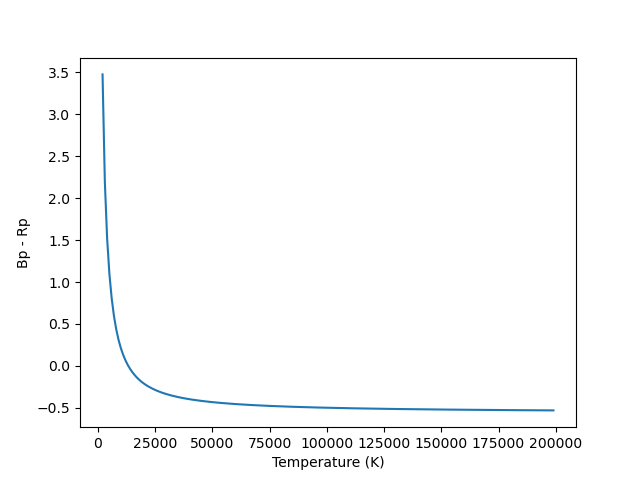

In [18]:
%pylab widget

plt.plot(pleiades_model_teff, colors)
plt.xlabel('Temperature (K)')
plt.ylabel('Bp - Rp')
plt.savefig('color_v_temperature.pdf')

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


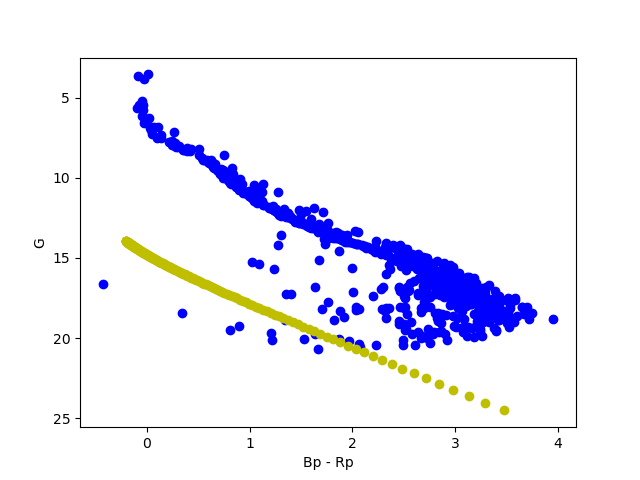

In [13]:
%pylab widget

#sun
# color, mag = model_star_cmd(5777 * u.K, const.R_sun, PLEIADES_DISTANCE)
#mandarin

#color, mag =  model_star_cmd(20000 * u.K, 1 * u.Rearth, PLEIADES_DISTANCE)
#plot([color], [mag], markersize=20, marker='o', color='green')


#color, mag =  model_star_cmd(3000 * u.K, 1000 * u.Rsun, PLEIADES_DISTANCE)
#plot([color], [mag], markersize=20, marker='o', color='orange')

plot(pleiades['phot_bp_mean_mag'] - pleiades['phot_rp_mean_mag'], pleiades['phot_g_mean_mag'], 'bo')
#plot(westerlund1_oc['phot_bp_mean_mag'] - westerlund1_oc['phot_rp_mean_mag'], westerlund1_oc['phot_g_mean_mag'], 'bo')
#plot(westerlund1_oc['BP-RP'], westerlund1_oc['Gmag'], marker='o', color='orange', ls='none')
plot(colors, mags, 'yo')

plt.gca().invert_yaxis()
#ylim(20, 0)
#loglog()

xlabel('Bp - Rp')
ylabel('G')
savefig('normal_pleiades_cmd_westerlund.pdf')

In [58]:
color, mag

(-0.4978664814938121, 14.496876892335342)

In [103]:
!open . 

In [30]:
col_names = "EEP          log10_isochrone_age_yr                    initial_mass                       star_mass                       star_mdot                    he_core_mass                     c_core_mass                           log_L                          log_LH                         log_LHe                        log_Teff                           log_R                           log_g                      surface_h1                     surface_he3                     surface_he4                     surface_c12                     surface_o16                    log_center_T                  log_center_Rho                    center_gamma                       center_h1                      center_he4                      center_c12                           phase".split()
data = pd.read_csv('MIST_iso_5gigayears.iso', delim_whitespace=True, comment='#', names=col_names)
data['R'] = 10**data.log_R
data['Teff'] = 10**data.log_Teff
data.sort_values('initial_mass', inplace=True)

mass_t_r_interpolator =  interpolate.interp1d(data.star_mass.values, data[['R', 'Teff']].values.T)

In [31]:
mass_t_r_interpolator(1.0)

array([   5.71268176, 4412.62941357])

In [88]:
m67_df = oc_df[oc_df['Cluster'] == 'NGC_2682']

In [89]:
m67_df

,RA_ICRS,DE_ICRS,Source,GLON,GLAT,plx,e_plx,pmRA,e_pmRA,pmDE,...,PlxpmDEcor,pmRApmDEcor,o_Gmag,Gmag,BP-RP,PMemb,Cluster,SimbadName,_RA.icrs,_DE.icrs
215596,132.946529,11.353877,598696077168308992,216.231465,31.816583,1.2339,0.1284,-10.911,0.223,-3.124,...,0.0447,-0.4416,342,17.438314,2.049427,0.5,NGC_2682,,132.946577,11.353890
215597,132.801300,11.310755,598694939001774976,216.206608,31.669308,1.1585,0.0276,-10.768,0.048,-2.795,...,-0.0267,-0.4326,321,13.923045,0.782881,0.5,NGC_2682,,132.801347,11.310767
215598,132.951477,11.302159,598692675554477056,216.289025,31.799104,1.1421,0.0337,-11.195,0.060,-2.794,...,-0.0375,-0.3202,318,14.430771,0.861522,0.7,NGC_2682,,132.951526,11.302171
215599,132.890835,11.380829,598697142320464384,216.175575,31.778487,1.1938,0.0379,-11.146,0.069,-2.894,...,-0.0523,-0.3395,337,12.622926,0.733996,0.7,NGC_2682,,132.890884,11.380841
215600,132.794558,11.317111,598695007721506432,216.196555,31.666007,1.1271,0.1204,-10.988,0.203,-2.999,...,-0.1256,-0.4283,308,17.276985,1.737898,0.4,NGC_2682,,132.794606,11.317124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216439,133.014778,11.689963,604903468852379904,215.905555,32.018819,1.1435,0.0390,-10.820,0.070,-2.762,...,-0.1497,-0.2256,340,12.585810,0.747308,0.9,NGC_2682,,133.014826,11.689975
216440,132.560995,11.741550,604960235430488960,215.631112,31.637087,1.1247,0.0374,-10.738,0.064,-2.846,...,-0.0156,-0.4244,345,14.946151,0.975459,0.8,NGC_2682,,132.561042,11.741562
216441,132.751692,11.901339,604922130480588544,215.552255,31.873467,1.1313,0.0886,-10.986,0.142,-3.063,...,0.0825,-0.4548,305,16.751854,1.504415,0.8,NGC_2682,,132.751740,11.901352
216442,132.748510,11.735564,604911096708974080,215.727950,31.801273,1.1991,0.0345,-11.159,0.061,-2.828,...,0.0603,-0.4910,308,14.437025,1.007396,0.8,NGC_2682,,132.748559,11.735576


In [91]:
m67_df.columns

Index(['RA_ICRS', 'DE_ICRS', 'Source', 'GLON', 'GLAT', 'plx', 'e_plx', 'pmRA',
       'e_pmRA', 'pmDE', 'e_pmDE', 'RADEcor', 'RAPlxcor', 'RApmRAcor',
       'RApmDEcor', 'DEPlxcor', 'DEpmRAcor', 'DEpmDEcor', 'PlxpmRAcor',
       'PlxpmDEcor', 'pmRApmDEcor', 'o_Gmag', 'Gmag', 'BP-RP', 'PMemb',
       'Cluster', 'SimbadName', '_RA.icrs', '_DE.icrs'],
      dtype='object')

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


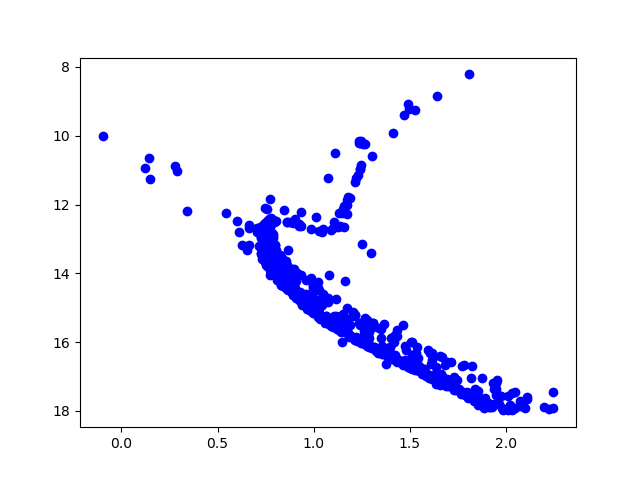

In [95]:
%pylab widget

plot(m67_df['BP-RP'], m67_df['Gmag'], 'bo')
plt.gca().invert_yaxis()